In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import xgboost
import catboost
import lightgbm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import optuna


In [2]:

# SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
#train test 데이터 불러오기
train = pd.read_csv('/Users/euijinlee/Downloads/대회 2/train.csv')
test = pd.read_csv('/Users/euijinlee/Downloads/대회 2/test.csv')

test.head()


,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,1_20240825 00,1,20240825 00,26.5,0.0,0.7,80.0
1,1_20240825 01,1,20240825 01,26.1,0.0,0.0,80.0
2,1_20240825 02,1,20240825 02,25.9,0.0,0.3,83.0
3,1_20240825 03,1,20240825 03,25.7,0.0,1.1,83.0
4,1_20240825 04,1,20240825 04,25.5,0.0,1.0,86.0


In [21]:
# train데이터 일/월/시간 컬럼 만들어서 붙이기
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

# test데이터 일/월/시간 컬럼 만들어서 붙이기
test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [22]:
# 상위5줄
train.head()

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,time
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,6,1,0
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,6,1,1
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,6,1,2
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,6,1,3
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,6,1,4


In [23]:
# 데이터정보
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(°C)         204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  month          204000 non-null  int64  
 11  day            204000 non-null  int64  
 12  time           204000 non-null  int64  
dtypes: float64(7), int64(4), object(2)
memory usage: 20.2+ MB


In [24]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', 'month', 'day', 'time'],
      dtype='object')

In [25]:
# 필요한 변수만 남겨놓기
train = train[['time','month', 'day','기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)']]

In [26]:
# from pycaret.regression import *

# setup_clf = setup(data=train, target='전력소비량(kWh)')
# class_top = compare_models()
# class_top

In [27]:
# 독립변수 종속변수 설정
X = train[['time','month', 'day','기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]
X_test = test[['time','month', 'day','기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]

y = train['전력소비량(kWh)']

In [28]:
# 데이터 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=49)

In [29]:
# 데이터 스케일링
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_valid = ss.transform(X_valid)
X_test = ss.transform(X_test)

In [30]:
# xgboost
def objectiveXGB(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0)
    }

    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)

In [31]:
# catboost
def objectiveCB(trial): 
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 10, 500),
        'od_wait':trial.suggest_int('od_wait', 10, 500),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0)

    }
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm.fit(X_train, y_train)
    y_pred = model_cbrm.predict(X_valid)
    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)


In [32]:
# lightGBM
def objectiveLGB(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }
    model_lgb = LGBMRegressor(**param)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_valid)
    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)



In [33]:
study_XGB = optuna.create_study(direction='maximize')
study_XGB.optimize(objectiveXGB,n_trials=100)

print('Best parameters', study_XGB.best_params)

[I 2026-02-05 07:50:26,610] A new study created in memory with name: no-name-0cf7aaa6-20c2-4e67-9bf2-51ba1c9e20ca
[I 2026-02-05 07:50:28,198] Trial 0 finished with value: 37.371101059889185 and parameters: {'max_depth': 10, 'learning_rate': 0.36083452590033305, 'n_estimators': 526, 'min_child_weight': 5, 'gamma': 0.5945385601618376}. Best is trial 0 with value: 37.371101059889185.
[I 2026-02-05 07:50:28,292] Trial 1 finished with value: 36.710895296046594 and parameters: {'max_depth': 2, 'learning_rate': 0.2843972354629021, 'n_estimators': 118, 'min_child_weight': 3, 'gamma': 0.7502260730838815}. Best is trial 0 with value: 37.371101059889185.
[I 2026-02-05 07:50:29,305] Trial 2 finished with value: 36.764576750164295 and parameters: {'max_depth': 5, 'learning_rate': 0.7810736717811795, 'n_estimators': 776, 'min_child_weight': 1, 'gamma': 0.2205541774484006}. Best is trial 0 with value: 37.371101059889185.
[I 2026-02-05 07:50:30,590] Trial 3 finished with value: 37.349407093728004 and 

Best parameters {'max_depth': 10, 'learning_rate': 0.9978984083534074, 'n_estimators': 1000, 'min_child_weight': 9, 'gamma': 0.8791189920459472}


In [ ]:
study_CB = optuna.create_study(direction='maximize')
study_CB.optimize(objectiveCB,n_trials=100)

print('Best parameters', study_CB.best_params)

In [35]:
study_LGB = optuna.create_study(direction='maximize')
study_LGB.optimize(objectiveXGB,n_trials=100)

print('Best parameters', study_LGB.best_params)

[I 2026-02-05 07:55:22,525] A new study created in memory with name: no-name-64aa39a2-1502-42f5-b9ec-296eee22433e
[I 2026-02-05 07:55:23,883] Trial 0 finished with value: 38.042318148779835 and parameters: {'max_depth': 8, 'learning_rate': 0.7489376378339143, 'n_estimators': 502, 'min_child_weight': 6, 'gamma': 0.0747272612219908}. Best is trial 0 with value: 38.042318148779835.
[I 2026-02-05 07:55:24,407] Trial 1 finished with value: 36.88796084887524 and parameters: {'max_depth': 1, 'learning_rate': 0.9380331212091859, 'n_estimators': 827, 'min_child_weight': 10, 'gamma': 0.40281350374412644}. Best is trial 0 with value: 38.042318148779835.
[I 2026-02-05 07:55:25,175] Trial 2 finished with value: 36.3816848179407 and parameters: {'max_depth': 5, 'learning_rate': 0.026653183055096404, 'n_estimators': 467, 'min_child_weight': 9, 'gamma': 0.3441270981183927}. Best is trial 0 with value: 38.042318148779835.
[I 2026-02-05 07:55:28,154] Trial 3 finished with value: 38.19557040582432 and pa

Best parameters {'max_depth': 10, 'learning_rate': 0.9992935336095978, 'n_estimators': 940, 'min_child_weight': 6, 'gamma': 0.6081163178899462}


In [36]:
print('XGB: ', study_XGB.best_params)
print('CB: ', study_CB.best_params)
print('LGB: ', study_LGB.best_params)

XGB:  {'max_depth': 10, 'learning_rate': 0.9978984083534074, 'n_estimators': 1000, 'min_child_weight': 9, 'gamma': 0.8791189920459472}
CB:  {'iterations': 22, 'od_wait': 209, 'learning_rate': 0.010652712587125121, 'reg_lambda': 11.394371952746356, 'subsample': 0.9379328628760881, 'random_strength': 19.159408853036084, 'depth': 1, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.42586059171013374, 'colsample_bylevel': 0.9130136789590892}
LGB:  {'max_depth': 10, 'learning_rate': 0.9992935336095978, 'n_estimators': 940, 'min_child_weight': 6, 'gamma': 0.6081163178899462}


In [37]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

base_models = [
    ('rf_1', XGBRegressor(**study_XGB.best_params)),
    ('rf_2', LGBMRegressor(**study_LGB.best_params))
]

reg = StackingRegressor(estimators=base_models, \
                   final_estimator=CatBoostRegressor(**study_CB.best_params))

reg.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 153000, number of used features: 7
[LightGBM] [Info] Start training from score 3335.089895
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 122400, number of used features: 7
[LightGBM] [Info] Start training from score 3341.805744


StackingRegressor(estimators=[('rf_1',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,
                                            gamma=0.8791189920459472,
                                            grow_policy=None,
                                            importance_type=None,
                                            inte...
                                            max_leaves=None, min_child_weight=9,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('rf_2',
                               LGBMRegressor(gamma=0.6081163178899462,
                                             learning_rate=0.9992935336095978,
                                             max_depth=10, min_child_weight=6,
                                             n_estimators=940))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x337656f50>)

In [38]:
pred = reg.predict(X_test)

submission = pd.read_csv('/Users/euijinlee/Downloads/open (3)/sample_submission.csv')
submission['answer'] = pred
submission.to_csv('submit2.csv', index = False)

[LightGBM] [Warning] Unknown parameter: gamma


In [67]:
#train test 데이터 불러오기
train = pd.read_csv('/Users/euijinlee/Downloads/대회 2/train.csv')
test = pd.read_csv('/Users/euijinlee/Downloads/대회 2/test.csv')

test.head()
test.shape

(16800, 7)

In [68]:
# train데이터 일/월/시간 컬럼 만들어서 붙이기
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

# test데이터 일/월/시간 컬럼 만들어서 붙이기
test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [69]:
test.shape

(16800, 10)

In [70]:
# 필요한 변수만 남겨놓기
X = train[['time','month', 'day','기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]
X_test = test[['time','month', 'day','기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']]
y = train['전력소비량(kWh)']

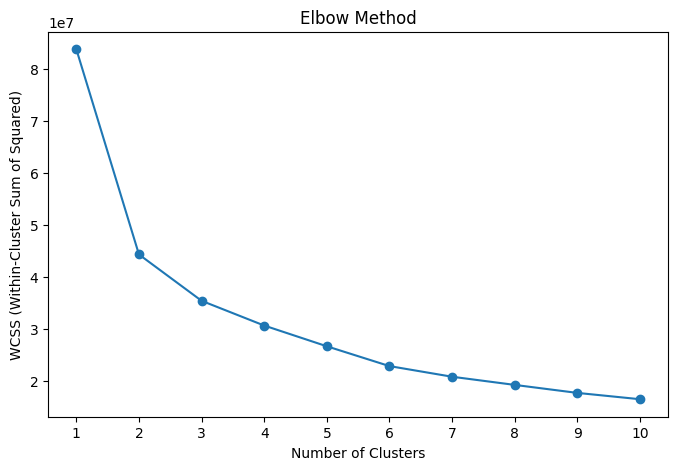

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

max_k = 10 
wcss = []

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k+1), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS (Within-Cluster Sum of Squared)")
plt.xticks(range(1, max_k+1))
plt.show()

In [17]:
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
for n_clusters in range(2, 11):  # 각 클러스터 개수에 대해 반복 실행

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # 실루엣 점수 함수
    silhouette_avg = silhouette_score(X, cluster_labels)  # 평균 실루엣 점수를 계산
    sample_silhouette_values = silhouette_samples(X, cluster_labels)  # 각 데이터 포인트의 실루엣 계수 계산

    # 실루엣 플롯을 위한 그래프 설정
    fig, ax = plt.subplots(figsize=(6, 4))
    y_lower = 10  # y축에서 시작하는 위치를 초기화 (10부터 시작)

    for i in range(n_clusters):  # 각 클러스터에 대해 반복
        # 클러스터 i의 실루엣 계수를 추출
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]  # 클러스터 i에 속한 데이터의 실루엣 값만 선택
        ith_cluster_silhouette_values.sort()  # 실루엣 계수를 정렬

        size_cluster_i = ith_cluster_silhouette_values.shape[0]  # 클러스터 i의 데이터 포인트 개수 계산
        y_upper = y_lower + size_cluster_i  # y_upper: 해당 클러스터가 끝나는 위치 계산

        # 클러스터 색상
        color = cm.nipy_spectral(float(i) / n_clusters)  # 클러스터별로 다른 색상을 지정
        # 클러스터 실루엣 계수 막대 그래프 그리기
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),  # y축 범위 설정
            0,  # x축에서 시작점 (0)
            ith_cluster_silhouette_values,  # 실루엣 계수를 x축에 표시
            facecolor=color,  # 채우기 색상
            edgecolor=color,  # 테두리 색상
            alpha=0.7,  # 투명도 설정
        )
        # 클러스터 번호
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))  # 클러스터 중앙에 번호 표시

        y_lower = y_upper + 10  # 다음 클러스터 y_lower를 갱신 (10 클러스터 간 간격)

    ax.set_title(f"Number of Cluster: {n_clusters} \nSilhouette Score: {silhouette_avg:.3f}")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    plt.show()


In [24]:
X

,time,month,day,기온(°C),강수량(mm),풍속(m/s),습도(%),kmeans_cluster
0,0,6,1,18.3,0.0,2.6,82.0,0
1,1,6,1,18.3,0.0,2.7,82.0,0
2,2,6,1,18.1,0.0,2.6,80.0,0
3,3,6,1,18.0,0.0,2.6,81.0,0
4,4,6,1,17.8,0.0,1.3,81.0,0
...,...,...,...,...,...,...,...,...
203995,19,8,24,29.1,0.0,4.4,76.0,0
203996,20,8,24,28.6,0.0,3.7,74.0,0
203997,21,8,24,28.3,0.0,2.9,74.0,0
203998,22,8,24,28.0,0.0,1.7,76.0,0


In [26]:
y

0         5794.80
1         5591.85
2         5338.17
3         4554.42
4         3602.25
           ...   
203995    3276.00
203996    3197.52
203997    3006.60
203998    2649.72
203999    2929.32
Name: 전력소비량(kWh), Length: 204000, dtype: float64

In [75]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split



kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_labels_test = kmeans.predict(X_test)

X['kmeans_cluster'] = kmeans_labels
X_test['kmeans_cluster'] = kmeans_labels_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=49)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- kmeans)cluster
Feature names seen at fit time, yet now missing:
- kmeans_cluster


In [21]:
from pycaret.regression import *


# pycaret으로 모델 성능 비교
setup_clf = setup(data=train, target='전력소비량(kWh)')
class_top = compare_models()
class_top

,Description,Value
0,Session id,4724
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 8)"
4,Transformed data shape,"(204000, 8)"
5,Transformed train set shape,"(142800, 8)"
6,Transformed test set shape,"(61200, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2419.8836,12748151.9861,3570.2645,0.0636,1.1374,3.4683,2.4310
lightgbm,Light Gradient Boosting Machine,2431.7964,12832115.6840,3581.9794,0.0574,1.1437,3.5905,0.3940
xgboost,Extreme Gradient Boosting,2426.8622,12835011.7000,3582.4006,0.0572,1.1388,3.4637,0.1000
gbr,Gradient Boosting Regressor,2456.2206,13018838.3011,3607.9573,0.0437,1.1519,3.7035,1.2400
lasso,Lasso Regression,2492.4846,13355945.9000,3654.3753,0.0190,1.1652,3.8115,0.0300
ridge,Ridge Regression,2492.4977,13355941.7000,3654.3748,0.0190,1.1652,3.8110,0.0290
lar,Least Angle Regression,2492.4977,13355941.9000,3654.3748,0.0190,1.1652,3.8110,0.0300
llar,Lasso Least Angle Regression,2492.4847,13355946.0000,3654.3753,0.0190,1.1652,3.8114,0.0270
br,Bayesian Ridge,2492.4743,13355982.1000,3654.3801,0.0190,1.1652,3.8122,0.0300
lr,Linear Regression,2492.4973,13355941.6000,3654.3747,0.0190,1.1652,3.8110,0.5090


In [76]:
# 데이터 스케일링
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_valid = ss.transform(X_valid)
X_test = ss.transform(X_test)

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.model_selection import cross_val_score, KFold

In [41]:
def DT_objective(trial):
    # 모델 선택
        # Decision Tree 하이퍼파라미터 탐색
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    model = DecisionTreeRegressor(
        max_depth=max_depth, 
        min_samples_split=min_samples_split
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)

In [42]:
def KNN_objective(trial):
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 2, 20) # Range can be adjusted
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int('p', 1, 2) # 1: Manhattan, 2: Euclidean

    # Initialize the KNeighborsRegressor with suggested hyperparameters
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Optuna works to minimize the return value by default
    # We return the negative mean of the scores to maximize the R^2 or minimize MSE
    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)

In [43]:
def HR_objective(trial):
    # Suggest hyperparameters
    epsilon = trial.suggest_float("epsilon", 1.0, 5.0)
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)

    # Create and fit model
    model = HuberRegressor(epsilon=epsilon, alpha=alpha, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_valid)
    
    return symmetric_mean_absolute_percentage_error(y_valid, y_pred)

In [44]:
KNN_study = optuna.create_study(direction='maximize')
KNN_study.optimize(KNN_objective,n_trials=100)

print('Best parameters', KNN_study.best_params)

[I 2026-02-08 08:05:51,227] A new study created in memory with name: no-name-c625e07a-3c25-4187-971d-a70157f42fe1
[I 2026-02-08 08:05:56,449] Trial 0 finished with value: 36.276442735438344 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 2}. Best is trial 0 with value: 36.276442735438344.
[I 2026-02-08 08:06:03,727] Trial 1 finished with value: 37.488800224183166 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}. Best is trial 1 with value: 37.488800224183166.
[I 2026-02-08 08:06:05,638] Trial 2 finished with value: 37.58068195530069 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1}. Best is trial 2 with value: 37.58068195530069.
[I 2026-02-08 08:06:11,759] Trial 3 finished with value: 37.65198081252644 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1}. Best is trial 3 with value: 37.65198081252644.
[I 2026-02-08 08:06:16,873

Best parameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}


In [45]:
DT_study = optuna.create_study(direction='maximize')
DT_study.optimize(DT_objective,n_trials=100)

print('Best parameters', KNN_study.best_params)

[I 2026-02-08 08:11:16,743] A new study created in memory with name: no-name-4edc65af-8985-419c-8e20-2cd12e1b2cab
[I 2026-02-08 08:11:17,020] Trial 0 finished with value: 36.60696993501307 and parameters: {'max_depth': 10, 'min_samples_split': 8}. Best is trial 0 with value: 36.60696993501307.
[I 2026-02-08 08:11:17,252] Trial 1 finished with value: 36.6158182806472 and parameters: {'max_depth': 10, 'min_samples_split': 10}. Best is trial 1 with value: 36.6158182806472.
[I 2026-02-08 08:11:17,370] Trial 2 finished with value: 37.06191125672331 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 2 with value: 37.06191125672331.
[I 2026-02-08 08:11:17,421] Trial 3 finished with value: 37.33337380269153 and parameters: {'max_depth': 2, 'min_samples_split': 4}. Best is trial 3 with value: 37.33337380269153.
[I 2026-02-08 08:11:17,590] Trial 4 finished with value: 36.801101344933755 and parameters: {'max_depth': 8, 'min_samples_split': 19}. Best is trial 3 with value: 37

Best parameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}


In [46]:
HR_study = optuna.create_study(direction='maximize')
HR_study.optimize(HR_objective,n_trials=100)

print('Best parameters', HR_study.best_params)

[I 2026-02-08 08:11:25,171] A new study created in memory with name: no-name-badcf2f2-40ea-4f1c-8a03-44d94714f30d
[I 2026-02-08 08:11:25,398] Trial 0 finished with value: 35.97637964031951 and parameters: {'epsilon': 2.53833249668596, 'alpha': 0.21729265314997045}. Best is trial 0 with value: 35.97637964031951.
[I 2026-02-08 08:11:25,566] Trial 1 finished with value: 37.133939280312 and parameters: {'epsilon': 3.9720717699250834, 'alpha': 0.004016264336674241}. Best is trial 1 with value: 37.133939280312.
[I 2026-02-08 08:11:25,786] Trial 2 finished with value: 35.210897318361994 and parameters: {'epsilon': 2.2600706595587914, 'alpha': 0.00042894194524299397}. Best is trial 1 with value: 37.133939280312.
[I 2026-02-08 08:11:26,004] Trial 3 finished with value: 35.780651482419785 and parameters: {'epsilon': 2.447055939865731, 'alpha': 0.0001859227006667034}. Best is trial 1 with value: 37.133939280312.
[I 2026-02-08 08:11:26,194] Trial 4 finished with value: 37.12511459797757 and parame

Best parameters {'epsilon': 4.9967074093873896, 'alpha': 0.9891167603518839}


In [47]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

base_models = [
    ('rf_1', DecisionTreeRegressor(**DT_study.best_params)),
    ('rf_2', KNeighborsRegressor(**KNN_study.best_params))
]

reg = StackingRegressor(estimators=base_models, \
                   final_estimator=HuberRegressor(**HR_study.best_params))

reg.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('rf_1',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='squared_error',
                                                     max_depth=2,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=7,
                                                     min_weight_fraction_leaf=0.0,
                                                     monotonic_cst=None,
                                                     random_state=None,
                                                     splitter='best')),
                              ('rf_2',
                               KNeighborsRegressor(algorithm='brute',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=2,
                                                   p=2, weights='distance'))],
                  final_estimator=HuberRegressor(alpha=0.9891167603518839,
                                                 epsilon=4.9967074093873896,
                                                 fit_intercept=True,
                                                 max_iter=100, tol=1e-05,
                                                 warm_start=False),
                  n_jobs=None, passthrough=False, verbose=0)

In [78]:
pred = reg.predict(X_test)

submission = pd.read_csv('/Users/euijinlee/Downloads/open (3)/sample_submission.csv')
#submission.shape
#pred.shape
submission['answer'] = pred
submission.to_csv('submit3.csv', index = False)